# KNN
Here we use K Nearest Neighbors algorithm to perform classification and regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from tqdm.notebook import tqdm

## Load Data

In [2]:
# training data:
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'
assays = assays.dropna(subset=['acvalue_scaled_to_tmprss2'])  # only use data that could be scaled

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

# Classification

## Load training data

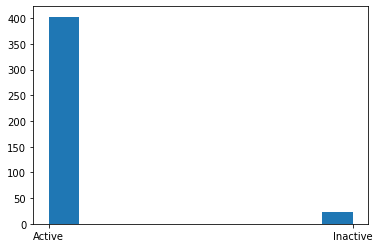

In [3]:
# set up features (X) and labels (y) for knn
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = assays.activity_target.values
assays_hist = plt.hist(y_assays)

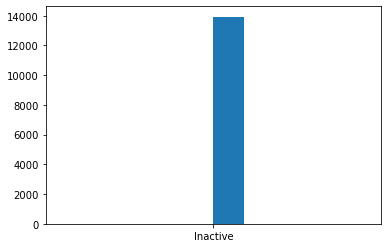

In [4]:
X_dcm = np.stack(dcm.sample(frac=.1).morgan_fingerprint)
y_dcm = ['Inactive'] * len(X_dcm)
dcm_hist = plt.hist(y_dcm)

### Validation

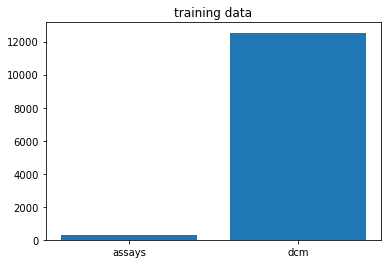

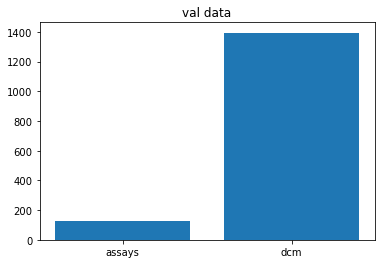

In [5]:
# make a validation set out of some of the assays and some of the dcm
percent_test_assays = .3  # Make the val set a bit less skewed than the train set
percent_test_dcm = .1    #
random_state = 3 # for reproducibility of train/val split

train_X_assays, val_X_assays, train_y_assays, test_y_assays = train_test_split(X_assays, y_assays, test_size=percent_test_assays, random_state=random_state)
train_X_dcm, val_X_dcm, train_y_dcm, test_y_dcm = train_test_split(X_dcm, y_dcm, test_size=percent_test_dcm, random_state=random_state)

plt.figure()
plt.bar(['assays', 'dcm'], [len(train_X_assays), len(train_X_dcm)])
plt.title('training data')

plt.figure()
plt.bar(['assays', 'dcm'], [len(val_X_assays), len(val_X_dcm)])
plt.title('val data')

train_X = np.concatenate([train_X_assays, train_X_dcm], axis=0)
val_X = np.concatenate([val_X_assays, val_X_dcm], axis=0)
train_y = np.concatenate([train_y_assays, train_y_dcm], axis=0)
test_y = np.concatenate([test_y_assays, test_y_dcm], axis=0)

## Optimize KNN Classifier using Validation Data

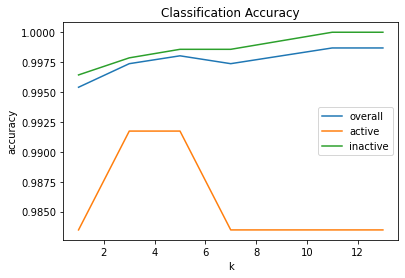

In [6]:
# optimize knn, test a couple ks

ks = np.arange(1, 14, 2)

accuracies = []
active_accuracies = []
inactive_accuracies = []
for k in tqdm(ks):
    nbrs = KNeighborsClassifier(n_neighbors=k, metric='jaccard', algorithm='ball_tree', n_jobs=32)
    nbrs.fit(train_X, train_y)
    pred = nbrs.predict(val_X)
    accuracies.append(np.count_nonzero(pred == test_y) / len(test_y))
    if np.count_nonzero(test_y == 'Inactive') == 0:
        inactive_accuracies.append(1)  # all inactive classified correctly: vacuously true
    else:
        inactive_accuracies.append(np.count_nonzero((pred == test_y) & (pred == 'Inactive')) / np.count_nonzero(test_y == 'Inactive'))
    if np.count_nonzero(test_y == 'Active') == 0:
        active_accuracies.append(1)
    else:
        active_accuracies.append(np.count_nonzero((pred == test_y) & (test_y == 'Active')) / np.count_nonzero(test_y == 'Active'))

plt.figure()
plt.plot(ks, accuracies, label='overall')
plt.plot(ks, active_accuracies, label='active')
plt.plot(ks, inactive_accuracies, label='inactive')
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title('Classification Accuracy')
plt.legend()

From the above experiment, we can see that k=5 does the best on active compounds; we'll choose this.

## Test on the Screening Data

In [7]:
# set up train and test
X_train = np.concatenate([X_assays, X_dcm])
y_train = np.concatenate([y_assays, y_dcm])

X_test = np.stack(screening_data.morgan_fingerprint)

print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 14359
Test set size: 21011


In [10]:
nbrs = KNeighborsClassifier(n_neighbors=3, metric='jaccard', algorithm='ball_tree', weights='distance', n_jobs=32) # turns out it gets much faster with many jobs (even 8x more jobs than my laptop's 4 physical cores).  64 is slower than 32 though, overhead catches up I guess.
nbrs.fit(train_X, train_y)

# chunk the test set in order to get some sense of progress
pred_activity = []
for test_chunk in tqdm(np.array_split(X_test, 100)):
    pred_activity.append(nbrs.predict(test_chunk))
pred_activity = np.concatenate(pred_activity)

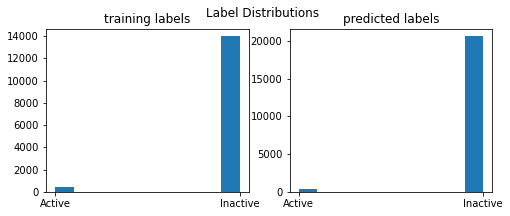

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].hist(y_train)
ax[0].set_title('training labels')
ax[1].hist(pred_activity)
ax[1].set_title('predicted labels')
t = plt.suptitle('Label Distributions')

We can see the screening data mostly comes back as inactive.  The distribution is similar to the training distribution, which could mean the model is biased by the training distribution, but this isn't necessarily true.  Could use a test with different training data distribution to see.

# Regression
Now that we have identified active compounds out of the screening data, we can regress the activity of these compounds using our assay data.

## Validation
### Load Train Data
Features are still morgan fingerprints, labels are log activity values.  Where available, the activity values are scaled to tmprss2 based on correlation between target activities.  Where correlation was unavailable, activity values are unscaled.


In [12]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.log10(assays.acvalue_scaled_to_tmprss2)
assert y_assays.isna().sum() == 0

### Regression Cross-Validation

Text(0.5, 1.0, '10-fold Cross Validation')

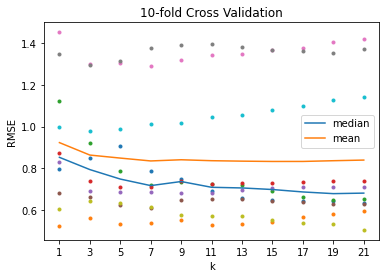

In [25]:
from sklearn.model_selection import cross_val_score
ks = np.arange(1, 23, 2)
RMSE = []
for k in tqdm(ks):
    knn_cv = KNeighborsRegressor(n_neighbors=k, metric='jaccard', weights='distance')
    RMSE.append(-cross_val_score(knn_cv, X_assays, y_assays, cv=10, scoring='neg_root_mean_squared_error'))
plt.plot(ks, RMSE, '.')
plt.plot(ks, np.median(RMSE, axis=1), label='median')
plt.plot(ks, np.mean(RMSE, axis=1), label='mean')
plt.xticks(ks)
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('k')
plt.title('10-fold Cross Validation')

From the cross-validation, it seems k=7 is a reasonable choice.

RMSE=0.7764739168696334


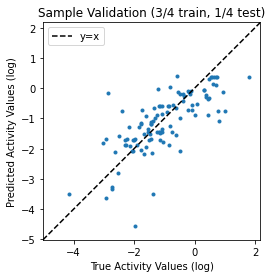

In [26]:
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X_assays, y_assays, test_size=.25, random_state=1)
nbrs = KNeighborsRegressor(n_neighbors=7, metric='jaccard', weights='distance')
nbrs.fit(X_train, y_train)
y_pred = nbrs.predict(X_test)

plt.plot(y_test, y_pred, '.')
plt.xlabel('True Activity Values (log)')
plt.ylabel('Predicted Activity Values (log)')
bnds = [np.min([y_test, y_pred])*1.1, np.max([y_test, y_pred])*1.2]
plt.axis('square')
plt.xlim(bnds)
plt.ylim(bnds)
plt.plot(np.linspace(*bnds), np.linspace(*bnds), 'k--', label='y=x')
plt.legend()
plt.title('Sample Validation (3/4 train, 1/4 test)')
print(f'RMSE={mean_squared_error(y_test, y_pred, squared=False)}')

Here you can see that the distribution as a whole looks good, but the accuracy in the low-end is poor.  Since we care about the low end, this is concerning.

### Load Test Data
The test data consists of all the screening molecules which were marked 'active' in classification above.

In [27]:
active_screening_data = screening_data[pred_activity=='Active']
X_test_active = np.stack(active_screening_data.morgan_fingerprint)

In [28]:
nbrs = KNeighborsRegressor(n_neighbors=7, metric='jaccard', weights='distance')
nbrs.fit(X_assays, y_assays)
pred_acvalue = nbrs.predict(X_test_active)

active_screening_data.insert(loc=2, column='predicted_acvalue(log10)', value=pred_acvalue)

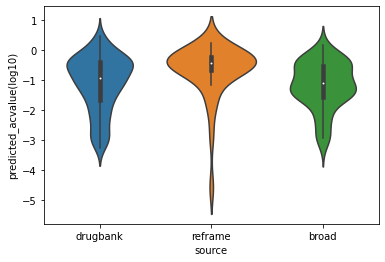

In [29]:
# a look at the predicted activity distributions by dataset source:
from seaborn import violinplot
violinplot(x='source', y='predicted_acvalue(log10)', data=active_screening_data)

In [30]:
# and the top hits!
active_screening_data.sort_values(by='predicted_acvalue(log10)').head(20)

,source,name,predicted_acvalue(log10),morgan_fingerprint
10797,reframe,Nafamostat,-4.573860,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
13540,broad,CTS21166,-3.261067,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8507,drugbank,Ipamorelin,-3.258770,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6887,drugbank,"1-[(4S)-4-amino-5-(1,3-benzothiazol-2-yl)-5-ox...",-3.230251,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1834,drugbank,L-N(omega)-nitroarginine-(4R)-amino-L-proline ...,-3.226611,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2513,drugbank,RWJ-56423,-3.215892,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8073,drugbank,Angiotensin II,-3.199554,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10554,drugbank,VM4-037,-3.136559,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7097,drugbank,DADLE,-3.132760,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8202,drugbank,Thymopentin,-3.121986,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Nafamostat comes in on top, which is reassuring.  The rest of the results... unclear.  Not a ton of trust in the KNN.